In [1]:
import tensorflow as tf

from pod.ai.manual import DQController
from pod.board import PodBoard
from pod.controller import Controller
from pod.drawer import Drawer
from pod.game import Player
from pod.util import PodState
from vec2 import Vec2
from IPython.display import Image


board = PodBoard([Vec2(5000, 4000), Vec2(12000, 7000)])
controller = DQController(board)

In [5]:
for epoch in range(0, 10):
    print("----- Epoch {} -----".format(epoch))
    controller.train_online(1000, epoch * 0.1, 1 - epoch * 0.1)

----- Epoch 0 -----
Iteration 0 loss 0.00091523677110672
Iteration 50 loss 1.5212091284411144e-06
Iteration 100 loss 4.124380211578682e-05
Iteration 150 loss 3.1937634048517793e-05
Iteration 200 loss 5.071457508165622e-06
Iteration 250 loss 7.140995148802176e-05
Iteration 300 loss 8.845044249028433e-06
Iteration 350 loss 4.0557890315540135e-05
Iteration 400 loss 7.100757648004219e-05
Iteration 450 loss 2.3916306872706627e-06
Iteration 500 loss 8.6461310274899e-05
Iteration 550 loss 3.362683855812065e-05
Iteration 600 loss 4.553019243758172e-05
Iteration 650 loss 9.533340198686346e-05
Iteration 700 loss 5.142504733157693e-07
Iteration 750 loss 0.00011832524614874274
Iteration 800 loss 5.42739152231686e-11
Iteration 850 loss 0.00031091910204850137
Iteration 900 loss 0.004048519767820835
Iteration 950 loss 0.026174888014793396
----- Epoch 1 -----
Iteration 0 loss 0.0009274163749068975
Iteration 50 loss 0.008065511472523212
Iteration 100 loss 0.016821755096316338
Iteration 150 loss 0.07531

In [ ]:
pods = controller.gen_pods(5,5,5,5,5)
for epoch in range(1, 4):
    print("----- stupid epoch {} -----".format(epoch))
    controller.train(pods, batch_size=30, use_best = True)

In [ ]:
controller.train(pods, batch_size=70, discount=0.2, epsilon=0.9)

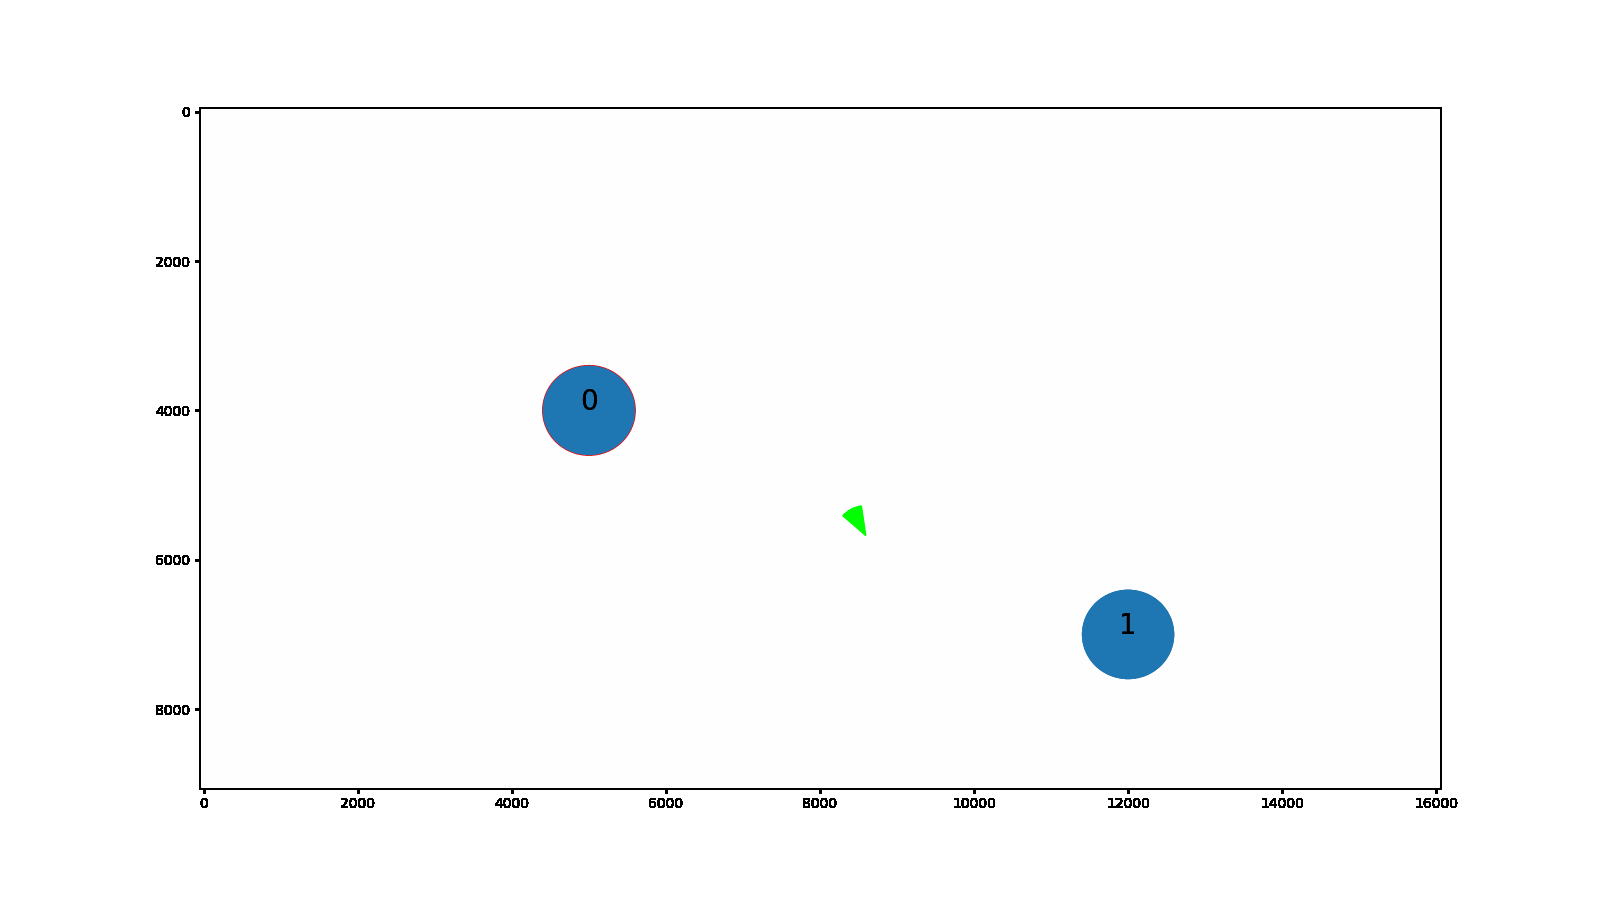

In [6]:
player = Player(controller, pod=PodState((board.get_check(0) + board.get_check(1)) * 0.5))
player.pod.angle = 1.23
drawer = Drawer(board, [player])

file = '/tf/notebooks/pods.gif'
drawer.animate(file, 100)
Image(filename = file)

In [ ]:
import numpy as np
import tensorflow as tf
from pod.ai.ai_utils import THRUST_VALUES, ANGLE_VALUES

BATCH_SIZE = 100

model = tf.keras.Sequential([
    tf.keras.layers.Dense(
        100,
        input_shape=(6,),
        activation="tanh"
    ),
    tf.keras.layers.Dense(
        100,
        activation="tanh"
    ),
    tf.keras.layers.Dense(
        THRUST_VALUES * ANGLE_VALUES
    )
])

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.mean_squared_error
)

target = np.zeros((BATCH_SIZE, THRUST_VALUES * ANGLE_VALUES))
target[...,0] = 1
for epoch in range(1, 100):
    batch = np.random.rand(BATCH_SIZE, 6)
    loss = model.train_on_batch(batch, target)
    print("Epoch {} loss {}".format(epoch, loss))

test_x = np.random.rand(1, 6)
test_y = model(tf.constant(test_x))
print("test_x = {}".format(test_x))
print("test_y = {}".format(test_y))